<a href="https://colab.research.google.com/github/dmzsdmws/ai_app_2022/blob/main/image_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170498071/170498071 [00:12<00:00, 13200315.47it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
データの数: 10000


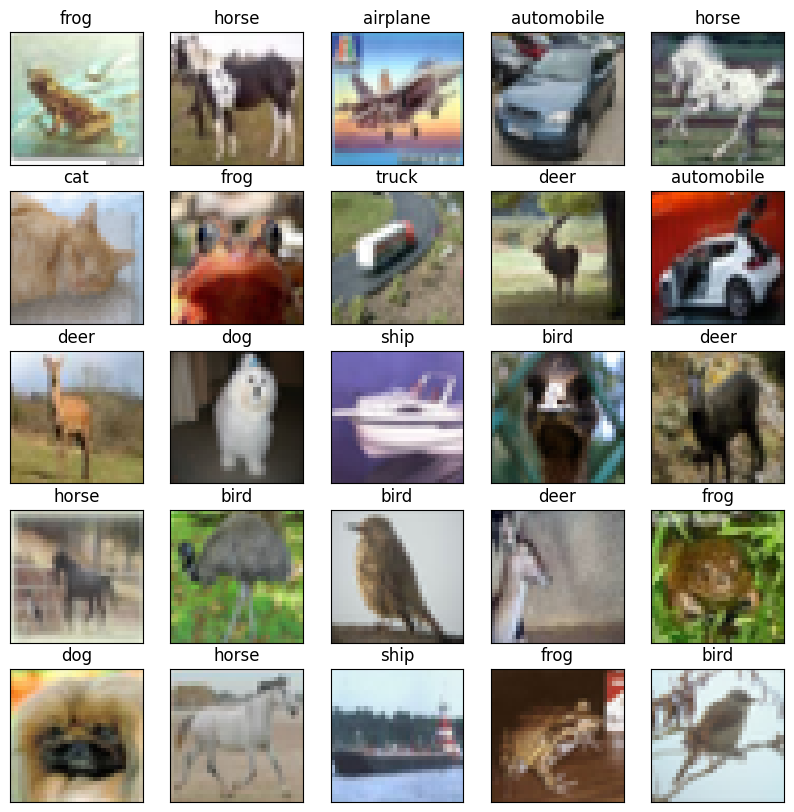

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

cifar10_data = CIFAR10(root="./data",
                       train=False,download=True,
                       transform=transforms.ToTensor())
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer",
                            "dog", "frog", "horse", "ship", "truck"])
print("データの数:", len(cifar10_data))

n_image = 25
cifar10_loader = DataLoader(cifar10_data, batch_size=n_image, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10,10))
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    label = cifar10_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

plt.show()

In [2]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))
flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)


batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層:(入力チャンネル数, フィルタ数、フィルタサイズ)
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層:（領域のサイズ, ストライド）
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # 全結合層
        self.dropout = nn.Dropout(p=0.5)  # ドロップアウト:(p=ドロップアウト率)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
from torch import optim

loss_fnc = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

x_test, t_test = next(iter(test_loader))
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(20):
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.7884400104317824 Loss_Test: 1.520037055015564
Epoch: 1 Loss_Train: 1.5614400617301922 Loss_Test: 1.4084819555282593
Epoch: 2 Loss_Train: 1.4917367233339782 Loss_Test: 1.3920259475708008
Epoch: 3 Loss_Train: 1.43838672808674 Loss_Test: 1.3117327690124512
Epoch: 4 Loss_Train: 1.404854417152112 Loss_Test: 1.2542839050292969
Epoch: 5 Loss_Train: 1.3717986275168026 Loss_Test: 1.28303861618042
Epoch: 6 Loss_Train: 1.350341092899937 Loss_Test: 1.2007594108581543
Epoch: 7 Loss_Train: 1.3288112854408791 Loss_Test: 1.1929219961166382
Epoch: 8 Loss_Train: 1.3112978759171712 Loss_Test: 1.1699415445327759
Epoch: 9 Loss_Train: 1.2918109705533518 Loss_Test: 1.1581097841262817
Epoch: 10 Loss_Train: 1.2812928527669833 Loss_Test: 1.1559648513793945
Epoch: 11 Loss_Train: 1.2780323567445322 Loss_Test: 1.1523791551589966
Epoch: 12 Loss_Train: 1.275707050814958 Loss_Test: 1.125930905342102
Epoch: 13 Loss_Train: 1.2588780500242471 Loss_Test: 1.1253066062927246
Epoch: 14 Loss_Train: 1.2

In [5]:
import torch

for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0])

# 保存
torch.save(net.state_dict(), "model_cnn.pth")

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.0545, -0.0784, -0.1523, -0.0221, -0.0902],
         [ 0.0853,  0.0447, -0.0811, -0.0951,  0.0387],
         [ 0.0419, -0.0172, -0.0356,  0.1243,  0.0050],
         [ 0.0532,  0.0120, -0.0727,  0.1510,  0.1350],
         [ 0.0876,  0.1705,  0.1019,  0.1835,  0.1057]],

        [[ 0.1950,  0.0140,  0.0134,  0.0063,  0.1466],
         [-0.0161,  0.2164, -0.0921, -0.0830,  0.1851],
         [ 0.1178,  0.0806, -0.1015,  0.1723,  0.1312],
         [ 0.1383, -0.0729, -0.0966,  0.0775, -0.0377],
         [ 0.1062,  0.1245, -0.0142,  0.0629, -0.0026]],

        [[-0.0129,  0.0705, -0.0950, -0.1122,  0.0248],
         [-0.0690, -0.0859, -0.1015, -0.0246, -0.0326],
         [-0.0014, -0.0953, -0.0683, -0.1327, -0